In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import itertools
from os import path
import pickle
from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
# %matplotlib notebook
plt.rcParams['figure.figsize'] = [20, 13]

import pandas as pd
pd.options.display.width = 200

slam_node_colors = {'gmapping': 'orange', 'slam_toolbox': 'blue', 'hector_slam': 'cyan'}


In [2]:
def load_cache(file_path):
    with open(path.expanduser(file_path), 'rb') as f:
        cache_dict = pickle.load(f)
        return cache_dict['df']

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [3]:
# load data from cache and rename columns
df_new_config = load_cache("/home/enrico/ds/performance_modelling/output/slam_new_config/run_data_per_waypoint_cache.pkl")
# df_many_odoms = load_cache("/home/enrico/ds/performance_modelling/output/slam_many_odoms/run_data_per_waypoint_cache.pkl")
# df = df_new_config.append(df_many_odoms)
df = df_new_config
df.rename(inplace=True, columns={
    'trajectory_length_trajectory_length': 'trajectory_length',
    'waypoint_relative_localization_error_translation_error_final': 'translation_error',
    'waypoint_relative_localization_error_rotation_error_final': 'rotation_error',
    'geometric_similarity_sensor_mean_of_translation_eigenvalues_ratio_all': 'tgs_cont',
    'lidar_visibility_mean_visible_ranges_ratio': 'lvr_cont',
    'waypoint_start_time': 'start_time_cont',
})

# refactor and extract additional parameters and metrics
df['linear_update'] = df['linear_angular_update'].apply(lambda x: x[0])
df['beta'] = df['beta'].apply(lambda x: max(x))
df['norm_translation_error'] = df.translation_error / df.trajectory_length
df['run_id'] = df['run_folder'].apply(lambda x: path.basename(x))
df['waypoint_index'] = df.sort_values('start_time_cont').groupby(df.run_id).cumcount()
df['accumulated_trajectory_length'] = df.sort_values('start_time_cont').groupby(df.run_id).trajectory_length.cumsum() - df.trajectory_length

# discretize continuous input metrics
df['tgs'] = pd.cut(df.tgs_cont, 10, labels=False)
df['lvr'] = pd.cut(df.lvr_cont, 10, labels=False)
df['start_time'] = pd.cut(df.start_time_cont, 10, labels=False)

# drop unnecessary datapoints
df = df[(
    ((df.slam_node == 'gmapping') | (df.slam_node == 'slam_toolbox')) & (df.linear_update == 0.5) |
    (df.slam_node == 'hector_slam') & (df.linear_update == 0.4)
)]
df = df[df.trajectory_length > 1]

# only keep necessary columns
robot_parameters = [
    'laser_scan_max_range',
    'laser_scan_fov_deg',
    'beta',
]
other_parameters = [
    'slam_node',
    'environment_name',
]
input_discretized_metrics = [
    'start_time',
    'tgs',
    'lvr',
]
input_continuous_metrics = [
    'waypoint_index',
    'accumulated_trajectory_length',
    'start_time_cont',
    'tgs_cont',
    'lvr_cont',
]
output_metrics = [
    'norm_translation_error',
]
df = df[
    robot_parameters +
    other_parameters +
    input_discretized_metrics +
    input_continuous_metrics +
    output_metrics
]

mrs = sorted(list(df.laser_scan_max_range.unique()))
fovs = sorted(list(df.laser_scan_fov_deg.unique()))
betas = sorted(list(df.beta.unique()))
betas_fovs = list(itertools.product(betas, fovs))

printmd("## Parameters and Their Values")
for c in robot_parameters + other_parameters + input_discretized_metrics:
    printmd("{:>30}".format(c), sorted(list(df[c].unique())))

## Parameters and Their Values

          laser_scan_max_range [3.5, 8.0, 15.0, 30.0]

            laser_scan_fov_deg [90, 180, 270, 359]

                          beta [0.0, 2.0]

                     slam_node ['gmapping', 'hector_slam', 'slam_toolbox']

              environment_name ['7A-2', 'airlab', 'fr079', 'office_b']

                    start_time [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

                           tgs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

                           lvr [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

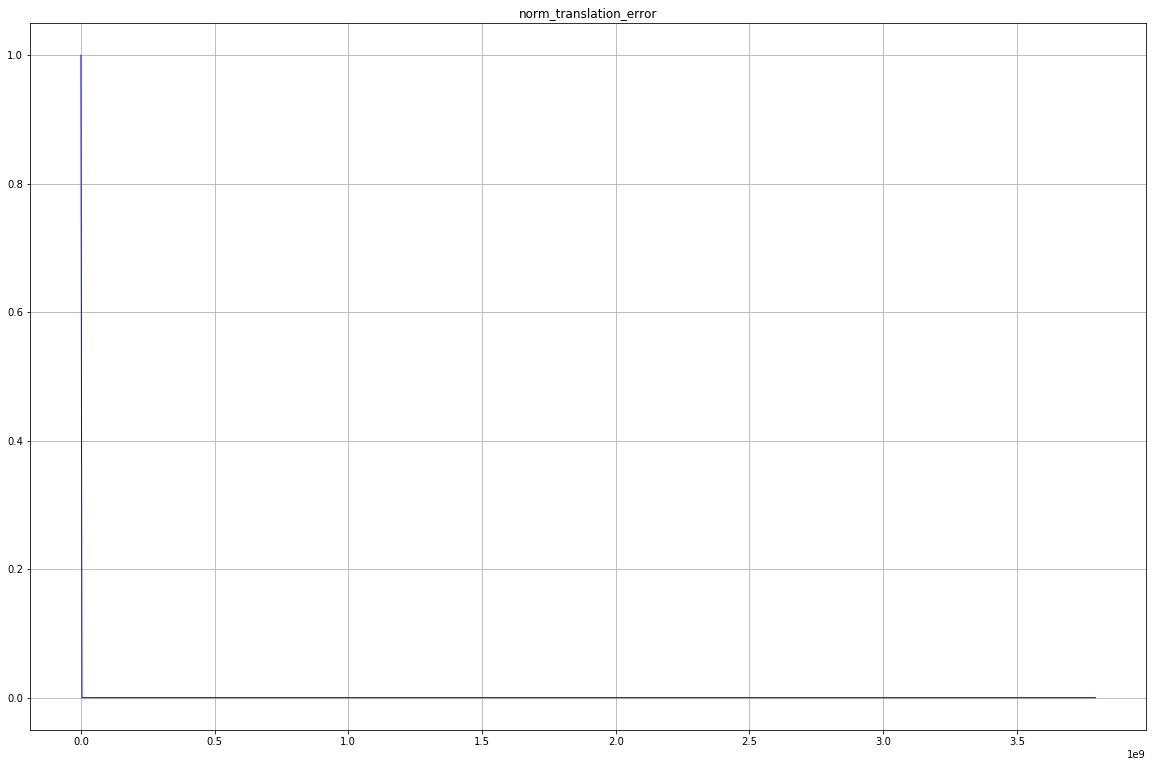

In [4]:
hist_metric = df[df.slam_node == 'hector_slam'].norm_translation_error
mean = hist_metric.mean()

x_lim_min = 0
x_lim_max = 1*mean
x = np.linspace(x_lim_min, x_lim_max, 1000)

h_y, h_x = np.histogram(hist_metric, bins=x)
n = len(hist_metric)
y = h_y/n

# s, loc, scale = ss.lognorm.fit(hist_metric)
# f = ss.lognorm.pdf(x, s, loc, scale)

# scale_corr = np.max(f)/np.max(y)
# print(scale_corr)

plt.plot(h_x[:-1], y, linewidth=1, color="blue")
# plt.plot(x, f, label="lognorm", linewidth=3, color='black')

# plt.xscale('log')
plt.title(hist_metric.name)
plt.grid(True)
plt.show()


/usr/lib/python3/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/lib/python3/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)


nan


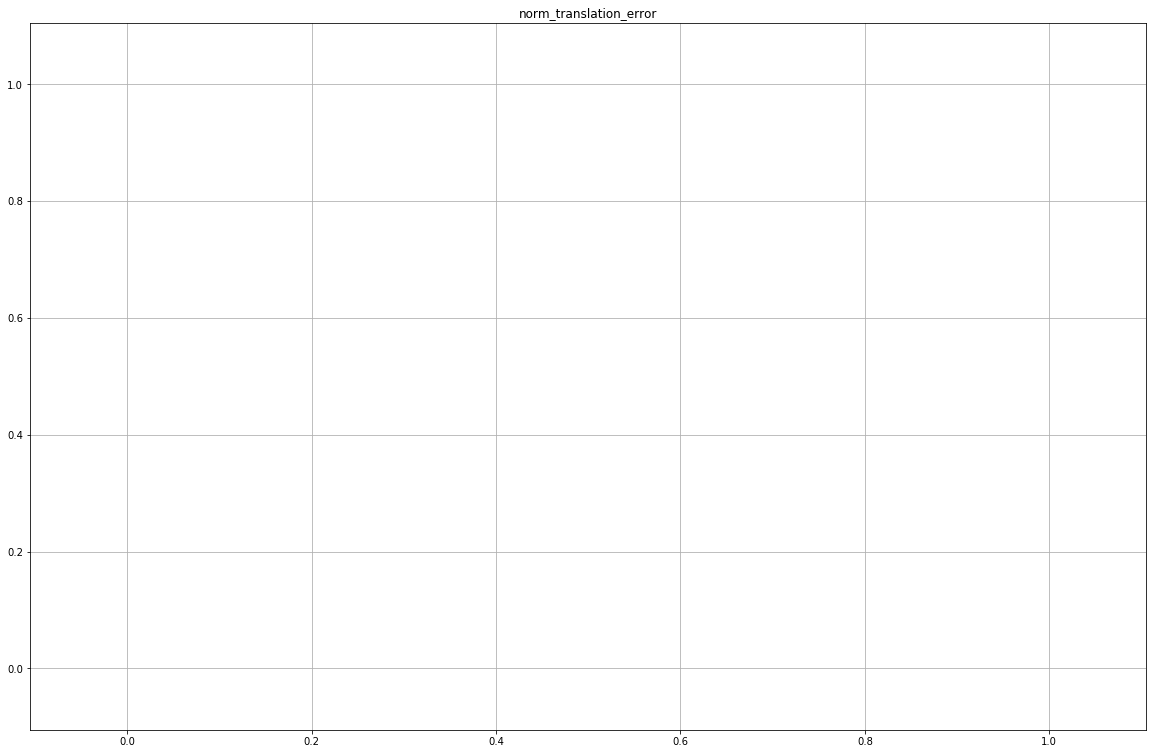

In [5]:
hist_metric = df.norm_translation_error
mean = hist_metric.mean()

x_lim_min = 0
x_lim_max = 1*mean
x = np.linspace(x_lim_min, x_lim_max, 1000)

h_y, h_x = np.histogram(hist_metric, bins=x)
n = len(hist_metric)
y = h_y/n

s, loc, scale = ss.lognorm.fit(hist_metric)
f = ss.lognorm.pdf(x, s, loc, scale)

scale_corr = np.max(f)/np.max(y)
print(scale_corr)

plt.plot(h_x[:-1], y * scale_corr, linewidth=1, color="blue")
plt.plot(x, f, label="lognorm", linewidth=3, color='black')

plt.title(hist_metric.name)
plt.grid(True)
plt.show()


AttributeError: 'AxesSubplot' object has no attribute 'sharex'

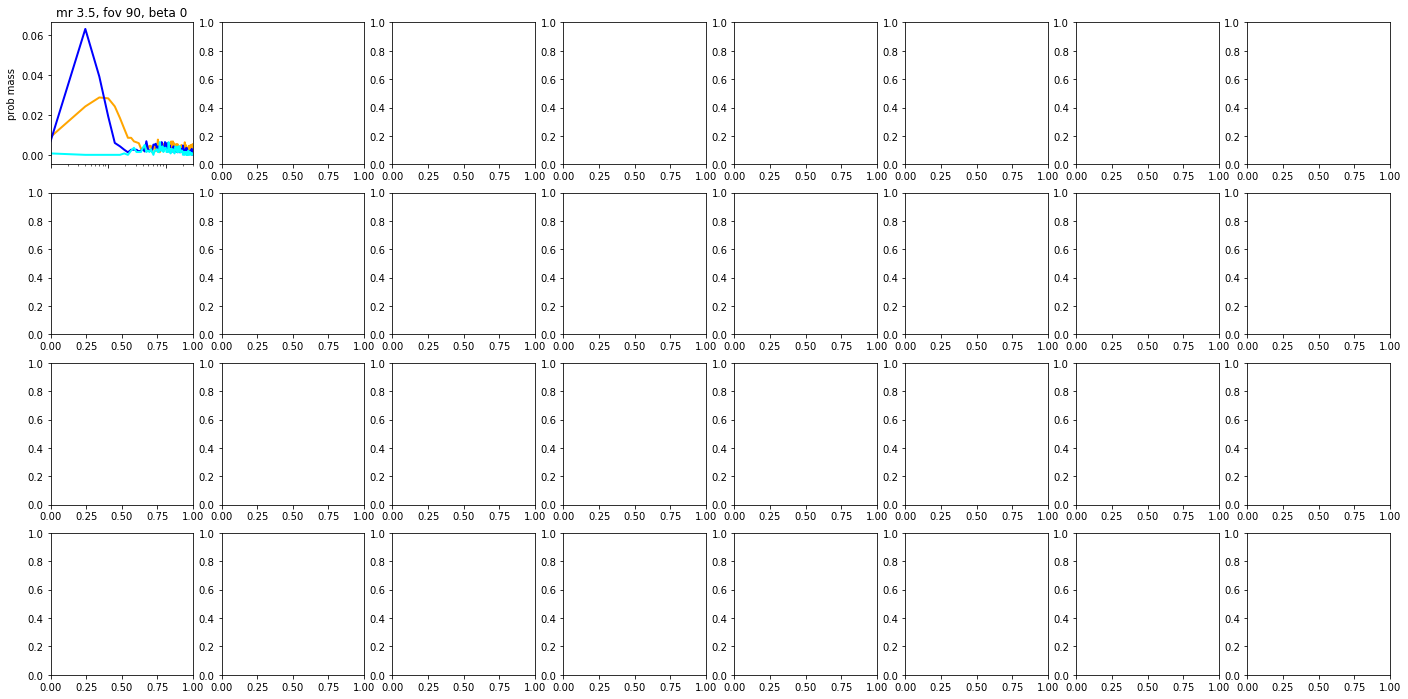

In [6]:
hist_metric = df.norm_translation_error
mean = hist_metric.mean()
x_lim_min = 0.0001
x_lim_max = 0.03
x = np.linspace(x_lim_min, x_lim_max, 100)
mrs = sorted(list(df.laser_scan_max_range.unique()))
fovs = sorted(list(df.laser_scan_fov_deg.unique()))
betas = sorted(list(df.beta.unique()))
betas_fovs = list(itertools.product(betas, fovs))

fig, axs = plt.subplots(len(mrs), len(betas_fovs))
fig.set_size_inches([24, 12])
axs[0, 0].set_xscale('log')
axs[0, 0].set_xlim(x_lim_min, x_lim_max)

for i, mr in enumerate(mrs):
    for j, (beta, fov) in enumerate(betas_fovs):
        for slam_node in df.slam_node.unique():
            df_ = df[
                (df.slam_node == slam_node) &
                (df.laser_scan_max_range == mr) &
                (df.laser_scan_fov_deg == fov) &
                (df.beta == beta)
            ]
            h_y, h_x = np.histogram(df_[hist_metric.name], bins=x)
            n = len(df_[hist_metric.name])
            axs[i, j].plot(h_x[:-1], h_y/n, linewidth=2, color=slam_node_colors[slam_node])
            axs[i, j].scatter(df_[hist_metric.name].mean(), 0, color=slam_node_colors[slam_node])

        axs[i, j].set_title(f"mr {mr}, fov {fov}, beta {int(beta)}")
        axs[i, j].set(xlabel=hist_metric.name, ylabel='prob mass')
        axs[i, j].label_outer()
        axs[i, j].sharex(axs[0, 0])
        axs[i, j].sharey(axs[0, 0])
        axs[i, j].grid(True)

plt.grid(True)
plt.suptitle(f"{hist_metric.name} distribution")
plt.show()

In [ ]:
hist_metric = df.norm_translation_error
mean = hist_metric.mean()
x_lim_min = 0.0001
x_lim_max = 0.03
x = np.linspace(x_lim_min, x_lim_max, 5)
mrs = sorted(list(df.laser_scan_max_range.unique()))
betas = sorted(list(df.beta.unique()))
fovs = sorted(list(df.laser_scan_fov_deg.unique()))
tgss = sorted(list(df.tgs.unique()))
sts = sorted(list(df.start_time.unique()))
others = list(itertools.product(betas, fovs, tgss, sts))

# fig, axs = plt.subplots(len(mrs), len(others))
# fig.set_size_inches([24, 12])
# axs[0, 0].set_xscale('log')
# axs[0, 0].set_xlim(x_lim_min, x_lim_max)

for i, mr in enumerate(mrs):
    for j, (beta, fov, tgs, st) in enumerate(others):
        for slam_node in df.slam_node.unique():
            df_ = df[
                (df.slam_node == slam_node) &
                (df.laser_scan_max_range == mr) &
                (df.beta == beta) &
                (df.laser_scan_fov_deg == fov) &
                (df.tgs == tgs) &
                (df.start_time == st)
            ]
            h_y, h_x = np.histogram(df_[hist_metric.name], bins=x)
            n = len(df_[hist_metric.name])
#             n = hist_metric.count()
            plt.plot(h_x[:-1], h_y/n, linewidth=2, color=slam_node_colors[slam_node])
            plt.scatter(df_[hist_metric.name].mean(), 0, color=slam_node_colors[slam_node])

        plt.title(f"mr {mr}, fov {fov}, beta {int(beta)}")
        plt.xlabel(hist_metric.name)
        plt.ylabel('prob mass')
#         plt.label_outer()
#         plt.sharex(axs[0, 0])
#         plt.sharey(axs[0, 0])
        plt.grid(True)
        plt.suptitle(f"{hist_metric.name} distribution")
        plt.show()

In [ ]:
hist_metric = df.norm_translation_error
mean = hist_metric.mean()
x_lim_min = 0
x_lim_max = 0.5*mean
x = np.linspace(x_lim_min, x_lim_max, 100)
tgs_values = sorted(list(df.tgs.unique()))

fig, axs = plt.subplots(len(tgs_values))
fig.set_size_inches([10, 30])
for i, tgs in enumerate(tgs_values):
    for slam_node in df.slam_node.unique():
        df_ = df[
            (df.slam_node == slam_node) &
            (df.tgs == tgs)
        ]
        h_y, h_x = np.histogram(df_[hist_metric.name], bins=x)
        n = len(df_[hist_metric.name])
        axs[i].plot(h_x[:-1], h_y/n, linewidth=2, color=slam_node_colors[slam_node])
        axs[i].scatter(df_[hist_metric.name].mean(), 0, color=slam_node_colors[slam_node])

    axs[i].set_title(f"tgs {tgs}")
    axs[i].set(xlabel=hist_metric.name, ylabel='prob mass')
    axs[i].label_outer()
    axs[i].set_xlim(x_lim_min, x_lim_max)
    axs[i].sharex(axs[0])
    axs[i].sharey(axs[0])
    axs[i].grid(True)

plt.grid(True)
plt.show()

In [ ]:

hist_metric = df.norm_translation_error
mean = hist_metric.mean()
x_lim_min = 0
x_lim_max = 3*mean
x = np.linspace(x_lim_min, x_lim_max, 100)
start_time_values = sorted(list(df.start_time.unique()))

fig, axs = plt.subplots(len(start_time_values))
fig.set_size_inches([30, 40])
for i, start_time in enumerate(start_time_values):
    for slam_node in df.slam_node.unique():
        df_ = df[
            (df.slam_node == slam_node) &
            (df.start_time == start_time)
        ]
        h_y, h_x = np.histogram(df_[hist_metric.name], bins=x)
        n = len(df_[hist_metric.name])
        axs[i].plot(h_x[:-1], h_y/n, linewidth=2, color=slam_node_colors[slam_node])
        axs[i].scatter(df_[hist_metric.name].mean(), 0, color=slam_node_colors[slam_node])

    axs[i].set_title(f"start_time {start_time}")
    axs[i].set(xlabel=hist_metric.name, ylabel='prob mass')
    axs[i].label_outer()
    axs[i].set_xlim(x_lim_min, x_lim_max)
    axs[i].sharex(axs[0])
    axs[i].sharey(axs[0])
    axs[i].grid(True)

plt.grid(True)
plt.show()

In [ ]:
# %matplotlib notebook

hist_metric = df.norm_translation_error
mean = hist_metric.mean()
x_lim_min = 0
x_lim_max = 1.0*mean
x = np.linspace(x_lim_min, x_lim_max, 50)
h_y, h_x = np.histogram(df.norm_translation_error, bins=x)
n = len(hist_metric)

max_y = 0.0
h_y_plots = [
    dict(),
    dict(),
]
for start_time in df.start_time.unique():
    
    df_start_time = df[df.start_time == start_time].norm_translation_error
    n = len(df_start_time)
    h_y, _ = np.histogram(df_start_time, bins=x)
    h_y_plots[0][start_time] = h_y/n
    max_y = np.max(h_y_plots[0][start_time])*1.1

fig, ax = plt.subplots()
line, = ax.plot(h_x[:-1], h_y_plots[0][df.start_time.max()], linewidth=3, color="black")
ax.set_xlabel(hist_metric.name)
ax.set_ylim(0, max_y)
ax.grid(True)
plt.show()

def update(change):
    t = change.new
    line.set_ydata(h_y_plots[0][t])
    fig.canvas.draw()

int_slider = widgets.IntSlider(value=df.start_time.max(), min=df.start_time.min(), max=df.start_time.max(), step=1, description='start_time')
int_slider.observe(update, 'value')
int_slider

In [ ]:

x_lim_min = 0
x_lim_max = 1.0*mean
x = np.linspace(x_lim_min, x_lim_max, 50)
h_y, h_x = np.histogram(df.norm_translation_error, bins=x)
n = len(hist_metric)

fig, ax = plt.subplots()
line, = ax.plot(h_x[:-1], h_y/n, linewidth=3, color="black")
ax.set_xlabel(hist_metric.name)
ax.set_ylim(0, 0.01)
ax.grid(True)
plt.show()


def update(change):
    t = change.new
    h_y, h_x = np.histogram(df[df.waypoint_index == t].norm_translation_error, bins=x)
    line.set_ydata(h_y/n)
#     ax.set_ylim(0, np.max(h_y)/n*1.1)
    fig.canvas.draw()

int_slider = widgets.IntSlider(value=df.waypoint_index.min(), min=0, max=df.waypoint_index.max(), step=1, description='waypoint_index')
int_slider.observe(update, 'value')
int_slider

In [ ]:
plt.xlabel('translation geometric similarity')
for env_name in df.environment_name.unique():
    df_hist = df[df.environment_name == env_name].groupby(df.tgs).tgs.count()
    plt.plot(df_hist.index, df_hist, label=env_name, linewidth=3)
plt.legend()
plt.grid(True)

plt.suptitle("geometric similarity (sensor) distribution by environment")
plt.show()

In [ ]:
plt.xlabel('lvr')
for env_name in df.environment_name.unique():
    df_hist = df[df.environment_name == env_name].groupby(df.lvr).lvr.count()
    plt.plot(df_hist.index, df_hist, label=env_name, linewidth=3)
plt.legend()
plt.grid(True)

plt.suptitle("lvr distribution by environment")
plt.show()